In [1]:
# Test migration history reconstruction on simulated data

import sys
import os

repo_dir = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/"
os.chdir(repo_dir)
from src.lib import vertex_labeling

from src.util import data_extraction_util as data_util
from src.util import vertex_labeling_util as vert_util
import matplotlib
import torch

MACHINA_DATA_DIR = os.path.join(repo_dir, 'src/data/machina_sims')


CUDA GPU: False
CUDA GPU: False
CUDA GPU: False


In [5]:
custom_colors = [matplotlib.colors.to_hex(c) for c in ['limegreen', 'cornflowerblue', 'hotpink', 'grey', 'saddlebrown', 'darkorange', 'purple', 'red', 'black', 'black', 'black', 'black']]
custom_colors = ["#6aa84fff","#c27ba0ff", "#be5742e1", "#6fa8dcff", "#e69138ff", "#9e9e9eff"]
def find_labelings_all_mutation_trees(cluster_fn, all_mut_trees_fn, ref_var_fn, use_gen_dist=False):
    cluster_label_to_idx = data_util.get_cluster_label_to_idx(cluster_fn, ignore_polytomies=True)
    data = data_util.get_adj_matrices_from_all_mutation_trees(all_mut_trees_fn, cluster_label_to_idx, is_sim_data=True)
    print("num trees:", len(data))
    i = 1
    for adj_matrix, pruned_cluster_label_to_idx in data:
        print(f"TREE {i}")
        T = torch.tensor(adj_matrix, dtype = torch.float32)
        B = vert_util.get_mutation_matrix_tensor(T)
        ref_matrix, var_matrix, unique_sites= data_util.get_ref_var_matrices_from_machina_sim_data(ref_var_fn, 
                                                                                                   pruned_cluster_label_to_idx=pruned_cluster_label_to_idx,
                                                                                                   T=T)
        G = data_util.get_genetic_distance_tensor_from_sim_adj_matrix(T, pruned_cluster_label_to_idx)
        G = G if use_gen_dist else None
        print("G\n", G)
        idx_to_label = {v:k for k,v in pruned_cluster_label_to_idx.items()}
        print(idx_to_label)
        print(unique_sites)   
        primary_idx = unique_sites.index('P')
        r = torch.nn.functional.one_hot(torch.tensor([primary_idx]), num_classes=len(unique_sites)).T
        weights = vertex_labeling.Weights(data_fit=1.0, mig=10.0, comig=5.0, seed_site=1.0, reg=1.0, gen_dist=0.5)
        print_config = vertex_labeling.PrintConfig(visualize=True, verbose=True, viz_intermeds=False)
        vertex_labeling.gumbel_softmax_optimization(T, ref_matrix, var_matrix, B, ordered_sites=unique_sites, 
                                                    weights=weights, p=r, node_idx_to_label=idx_to_label, G=G,
                                                    batch_size=16, init_temp=30, final_temp=0.01, 
                                                    print_config=print_config, custom_colors=custom_colors)
        print("*"*100)
        i += 1

import pydot
from IPython.display import Image, display

def visualize_ground_truth(tree_fn, graph_fn):
    def view_pydot(pdot):
        plt = Image(pdot.create_png())
        display(plt)
    
    (graph,) = pydot.graph_from_dot_file(tree_fn)
    view_pydot(graph)

    (graph,) = pydot.graph_from_dot_file(graph_fn)
    view_pydot(graph)
        
        

Ground truth


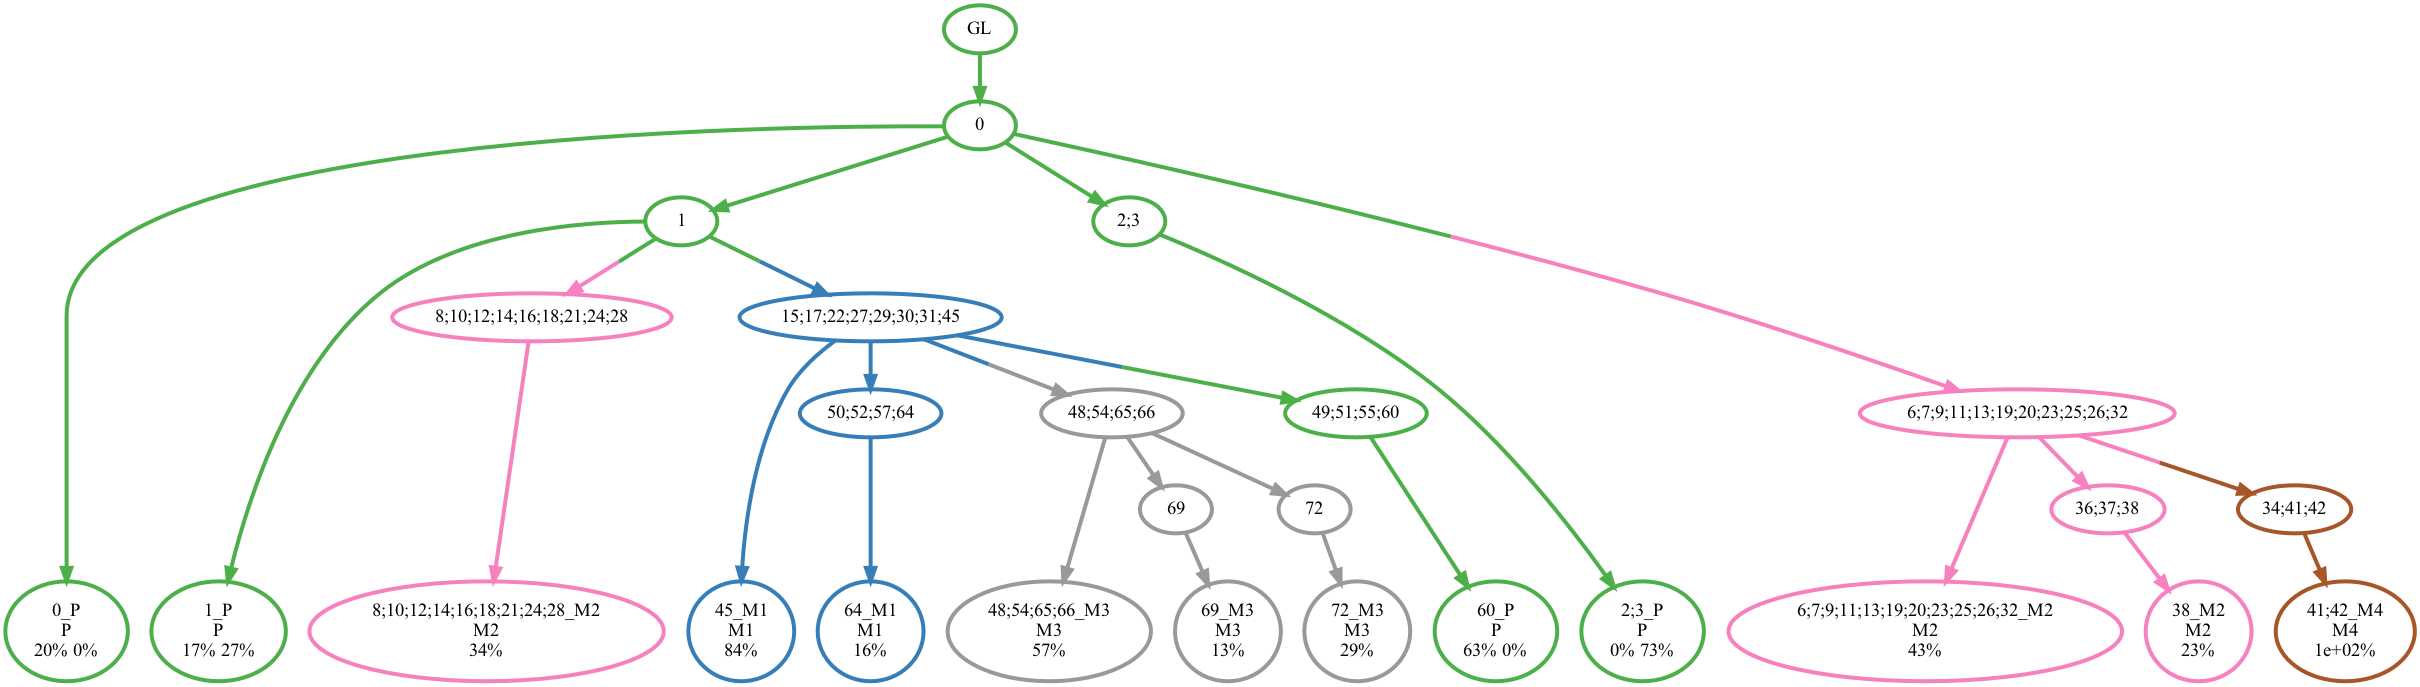

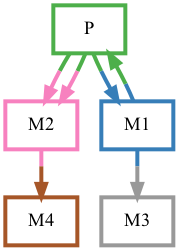

In [6]:
num_sites = "m5"
mig_type = "R"
SEED = 518
SIM_DATA_DIR = os.path.join(MACHINA_DATA_DIR, num_sites, mig_type)

print("Ground truth")
visualize_ground_truth(os.path.join(SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(SIM_DATA_DIR, f"G_seed{SEED}.dot"))


num trees: 2
TREE 1
G
 None
{0: '0', 1: '1', 2: '2;3', 3: '6;7;9;11;13;19;20;23;25;26;32', 4: '8;10;12;14;16;18;21;24;28;36;37;38', 5: '34;41;42', 6: '15;17;22;27;29;30;31;45', 7: '49;51;55;60', 8: '50;52;57;64', 9: '48;54;65;66', 10: '69;72'}
['P', 'M1', 'M2', 'M3', 'M4']


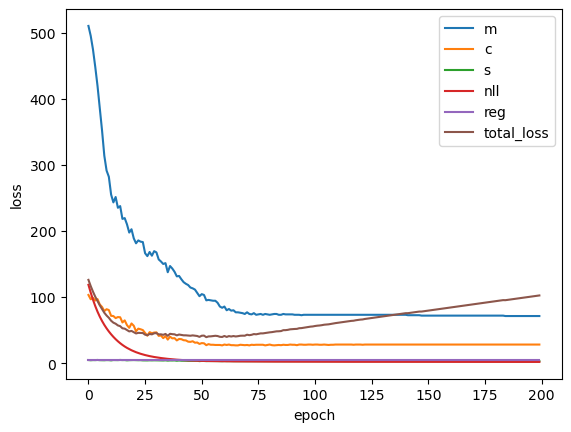

Time elapsed: 5.059063
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 6.0
Comigration number: 5.0
Seeding site number: 3.0
Neg log likelihood: 1.833
Reg: 5.0
Loss: 94.833


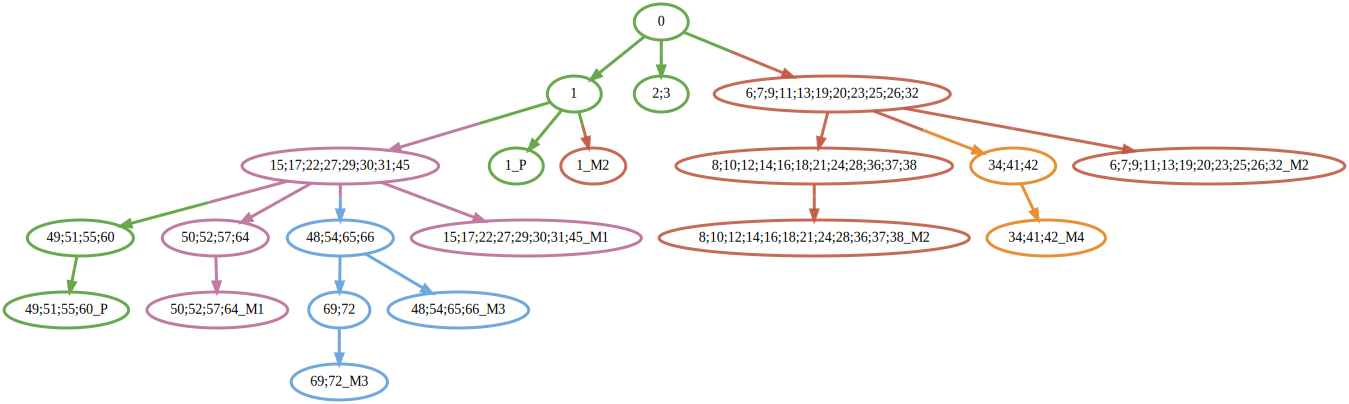

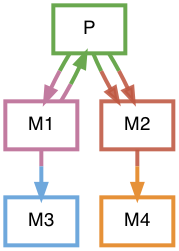

losses tensor
 tensor([ 94.1558,  94.8631, 104.8206, 104.8364, 104.8603, 109.8172, 109.8349,
        109.8593, 109.8601, 109.8614, 109.8696, 109.9163, 114.9107, 119.7968,
        119.8506, 119.8654])
****************************************************************************************************
TREE 2
G
 None
{0: '0', 1: '1', 2: '2;3', 3: '6;7;9;11;13;19;20;23;25;26;32', 4: '8;10;12;14;16;18;21;24;28;36;37;38', 5: '34;41;42', 6: '15;17;22;27;29;30;31;45', 7: '49;51;55;60', 8: '50;52;57;64', 9: '48;54;65;66', 10: '69;72'}
['P', 'M1', 'M2', 'M3', 'M4']


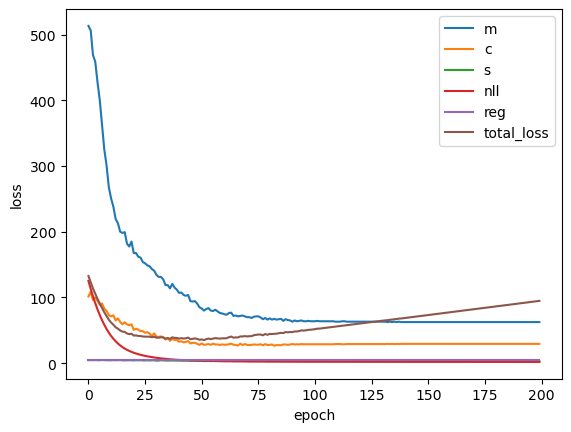

Time elapsed: 4.813303
print_config.k_best_trees 1
****************************** BEST TREE ******************************

Migration number: 6.0
Comigration number: 5.0
Seeding site number: 2.0
Neg log likelihood: 1.844
Reg: 5.000000476837158
Loss: 93.844


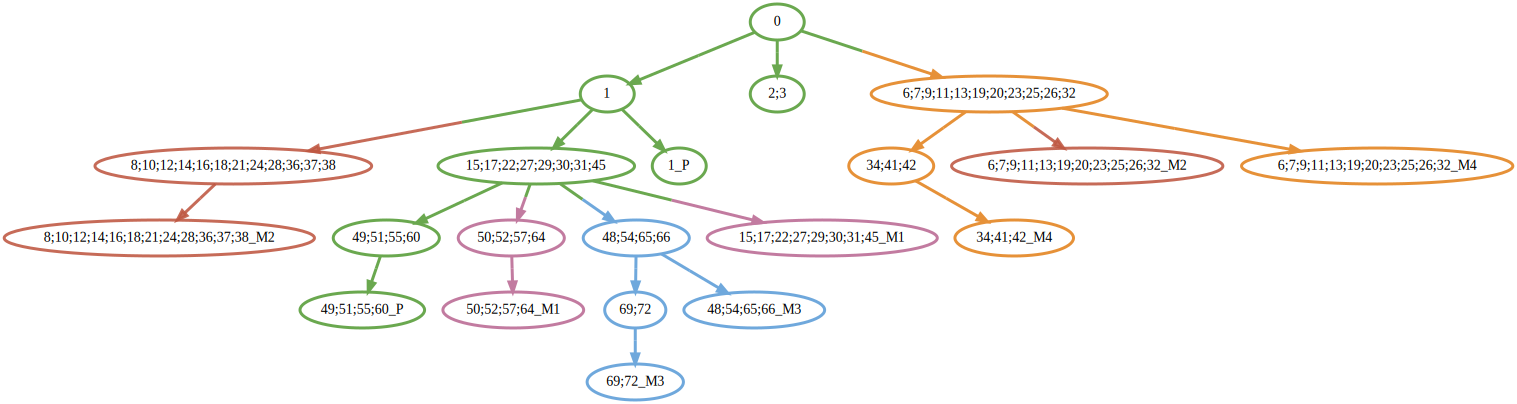

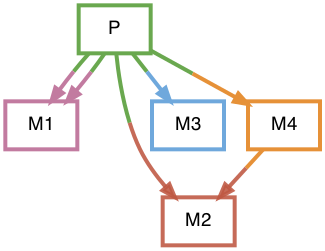

losses tensor
 tensor([ 93.2259,  93.8577,  99.8164,  99.8458,  99.8619,  99.8685,  99.8740,
         99.8986,  99.9090,  99.9180,  99.9312,  99.9402, 109.8434, 109.8824,
        109.9293, 109.9413])
****************************************************************************************************
CPU times: user 14.9 s, sys: 16.8 s, total: 31.7 s
Wall time: 11.3 s


In [7]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=False)




In [ ]:
%%time

find_labelings_all_mutation_trees(os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_mut_trees", f"mut_trees_{mig_type}_seed{SEED}.txt"),
                                  os.path.join(MACHINA_DATA_DIR, f"{num_sites}_clustered_input", f"cluster_{mig_type}_seed{SEED}.tsv"),
                                  use_gen_dist=True)




In [ ]:
!which python


In [ ]:
p = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/test/machina_simulated_data/predictions_wm3_wc2_wg0.5_bs32_11032022"
p = os.path.join(p, num_sites, mig_type)
visualize_ground_truth(os.path.join(p, f"T_tree0_seed{SEED}.predicted.tree"), os.path.join(p, f"G_tree0_seed{SEED}.predicted.tree"))


In [ ]:
import fnmatch
import matplotlib.pyplot as plt
def count_trees(sims_data_dir):
    sites = ["m8", "m5"]
    mig_types = ["M", "mS", "R", "S"]
    tree_cts = []
    ct = 0
    seed_ct = 0
    for site in sites:
        for mig_type in mig_types:
            local_ct = 0
            site_mig_data_dir = os.path.join(sims_data_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_data_dir), 'reads_seed*.tsv')
            seeds = [s.replace(".tsv", "").replace("reads_seed", "") for s in seeds]
            for seed in seeds:
                all_mut_trees_fn = os.path.join(sims_data_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt")
                with open(all_mut_trees_fn, 'r') as f:
                    for line in f:
                        if "#trees" in line:
                            tree_ct = int(line.split()[0])
                            tree_cts.append(tree_ct)
                            if tree_ct > 50:
                                print("tree > 50 trees", site, mig_type, seed, tree_ct)
                            ct += tree_ct
                            local_ct += tree_ct
                            break
                seed_ct += 1
            print(site, mig_type, local_ct)
    print(tree_cts)
    plt.hist(tree_cts)
    plt.show()
    plt.close()
    print("Number of total trees:", ct)

count_trees(MACHINA_DATA_DIR)
count_trees(RERUN_SIM_DIR)

In [ ]:
fn = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test.txt"
fn2 = "/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/results_8cores_time_test2.txt"
from datetime import datetime

output = []
with open(fn) as f:
    for i,line in enumerate(f):
        items = line.strip().split(',')
        if i != 0:
            epoch_time = datetime(1900, 1, 1)
            
            secs = (datetime.strptime(items[4][items[4].find('days')+5:], "%H:%M:%S.%f") - epoch_time).total_seconds()
            #print(secs)
            items[4] = secs
            #print(items)
            output.append(items)
        else:
            output.append(items)

print(output)
import csv
with open(fn2, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter=',', lineterminator='\n')
    for line in output:
        writer.writerow(line)

In [ ]:
mig_type = "S"
SEED = 23

RERUN_SIM_DIR = os.path.join(repo_dir, 'src/data/rerun_machina_sims')
RERUN_SIM_DATA_DIR = os.path.join(RERUN_SIM_DIR, num_sites, mig_type)

print("Manually generated sims")
visualize_ground_truth(os.path.join(RERUN_SIM_DATA_DIR, f"T_seed{SEED}.dot"), os.path.join(RERUN_SIM_DATA_DIR, f"G_seed{SEED}.dot"))


In [ ]:
import numpy as np
epoch = 10
x = max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))
x
#np.max(0.01, 1.0/(1.0+np.exp(-1.0*(epoch-10))))